# SISO Downlink NOMA

## System Model

<div align="center">
<img src="../resources/dl_noma.png" width="500">
</div>

<div align="center">
Fig. 1. Downlink NOMA system model.
</div>

Consider a simple downlink NOMA system with a single base station ($\mathrm{BS}$), a cell-center user ($\mathrm{UE}_n$) and a cell-edge user ($\mathrm{UE}_f$).

_For the sake of simplicity, assume that both base station and users are equipped with a single antenna._

Let $x_n$ and $x_f$ denote the messages intended for $\mathrm{UE}_n$ and $\mathrm{UE}_f$, respectively. The $\mathrm{BS}$ transmits a superposition of the two messages weighted by the power allocation coefficients $\alpha_n$ and $\alpha_f$, respectively. Mathematically, the transmitted signal can be expressed as

$$
x = \sqrt{\alpha_n P_t} x_n + \sqrt{\alpha_f P_t} x_f,
$$

where $P_t$ is the transmit power of the $\mathrm{BS}$.

In NOMA, successive interference cancellation (SIC) is employed at the users to decode their intended messages. The optimal decoding order is in the order of increasing channel gains. Let $h_n$ and $h_f$ denote the channel gains of $\mathrm{UE}_n$ and $\mathrm{UE}_f$, respectively, then, for the present case, $|h_n|^2 > |h_f|^2$. As such, $\mathrm{UE}_n$ decodes the message intended for $\mathrm{UE}_f$ first and then cancels it from the received signal to decode its own message, while $\mathrm{UE}_f$ decodes its own message directly. Furthermore, the received signal at $\mathrm{UE}_i$, $i \in \{n, f\}$, can be expressed as

$$
y_i = h_i x + n_i,
$$

where $n_i$ is the additive white Gaussian noise (AWGN) at $\mathrm{UE}_i$ with zero mean and variance $\sigma_i^2$.

Assuming perfect SIC, the achievable rates at $\mathrm{UE}_n$ and $\mathrm{UE}_f$ are given by

$$
\begin{align*}
R_{f\,\rightarrow\,n} &= \log_2 \left(1 + \frac{\alpha_f P_t |h_n|^2}{\alpha_n P_t |h_n|^2 + N_0}\right),\\
R_n &= \log_2 \left(1 + \frac{\alpha_n P_t |h_n|^2}{N_0}\right), \\
R_f &= \log_2 \left(1 + \frac{\alpha_f P_t |h_f|^2}{\alpha_n P_t |h_f|^2 + N_0}\right),
\end{align*}
$$

where $N_0$ is the noise power spectral density, and $R_{f\,\rightarrow\,n}$ is the achievable data rate at $\mathrm{UE}_n$ before SIC.

## Simulation

In [1]:
from comyx.network import UserEquipment, BaseStation
from comyx.core import SISOCollection
from comyx.propagation import get_noise_power
from comyx.utils import pow2db, db2pow, dbm2pow, pow2dbm, get_distance

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (6, 4)

### Setup Environment

In [2]:
Pt = np.linspace(0, 40, 100)  # dBm
Pt_lin = dbm2pow(Pt)  # Watt
bandwidth = 1e6  # Bandwidth in Hz
frequency = 2.4e9  # Carrier frequency
temperature = 300  # Kelvin
mc = 100000  # Number of channel realizations

N0 = get_noise_power(temperature, bandwidth)  # dB
N0_lin = db2pow(N0)  # Watt

fading_args = {"type": "rayleigh", "sigma": 1 / 2}
pathloss_args = {
    "type": "reference",
    "alpha": 3,
    "p0": 20,
    "frequency": frequency,
}  # p0 is the reference power in dBm

In [3]:
BS = BaseStation("BS", position=[0, 0, 10], n_antennas=1, t_power=Pt_lin)
UEn = UserEquipment("UEn", position=[200, 200, 1], n_antennas=1)
UEf = UserEquipment("UEf", position=[350, 350, 1], n_antennas=1)

print("Distance between BS and UEn:", get_distance(BS.position, UEn.position))
print("Distance between BS and UEf:", get_distance(BS.position, UEf.position))

Distance between BS and UEn: 282.98586537139977
Distance between BS and UEf: 495.0565624249415


### Initialize Links

In [4]:
link_col = SISOCollection(realizations=mc)

# Add links to the collection
link_col.add_link([BS, UEn], fading_args, pathloss_args)
link_col.add_link([BS, UEf], fading_args, pathloss_args)

Verify $|h_n|^2 > |h_f|^2$

In [5]:
np.mean(link_col.get_magnitude("BS->UEn") ** 2) > np.mean(
    link_col.get_magnitude("BS->UEf") ** 2
)

True

### Compute Rates

As mentioned earlier, the achievable rates at $\mathrm{UE}_n$ and $\mathrm{UE}_f$ are given by

$$
\begin{align*}
R_n &= \log_2 \left(1 + \frac{\alpha_n P_t |h_n|^2}{N_0}\right), \\
R_f &= \log_2 \left(1 + \frac{\alpha_f P_t |h_f|^2}{\alpha_n P_t |h_f|^2 + N_0}\right),
\end{align*}
$$

As this notebook intends to give a simple illustration of NOMA, we assume that the power allocation coefficients are fixed. 

In particular, we set $\alpha_n = 0.25$ and $\alpha_f = 0.75$.

In [6]:
BS.allocations = {"UEn": 0.25, "UEf": 0.75}

UEn.sinr_pre = np.zeros((len(Pt), mc))
UEn.sinr = np.zeros((len(Pt), mc))
UEf.sinr = np.zeros((len(Pt), mc))
UEn.outage = np.zeros((len(Pt), 1))
UEf.outage = np.zeros((len(Pt), 1))

for i, p in enumerate(Pt_lin):
    p = BS.t_power[i]

    # Edge user
    UEf.sinr[i, :] = (
        BS.allocations["UEf"] * p * link_col.get_magnitude("BS->UEf") ** 2
    ) / (BS.allocations["UEn"] * p * link_col.get_magnitude("BS->UEf") ** 2 + N0_lin)

    # Center user
    UEn.sinr_pre[i, :] = (
        BS.allocations["UEf"] * p * link_col.get_magnitude("BS->UEn") ** 2
    ) / (BS.allocations["UEn"] * p * link_col.get_magnitude("BS->UEn") ** 2 + N0_lin)
    UEn.sinr[i, :] = (
        BS.allocations["UEn"] * p * link_col.get_magnitude("BS->UEn") ** 2
    ) / N0_lin

### Results

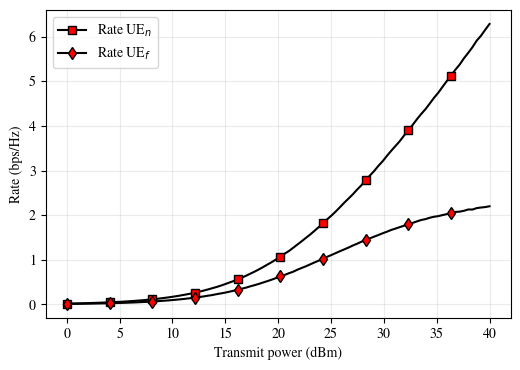

In [7]:
plot_args = {
    "markevery": 10,
    "color": "k",
    "markerfacecolor": "r",
}

# Plot achievable rates
plt.figure()
plt.plot(Pt, UEn.rate, label="Rate UE$_n$", marker="s", **plot_args)
plt.plot(Pt, UEf.rate, label="Rate UE$_f$", marker="d", **plot_args)
plt.xlabel("Transmit power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.grid(alpha=0.25)
plt.legend()
plt.show()